# Genetic alorithm

In [70]:
# Imports
import pickle

from deap import base
from deap import creator
from deap import tools

import numpy as np
from qiskit.primitives import Estimator

import sys
sys.path.append('../../')
import src.customFunc as cf
import src.ansatzs as anz

from heapq import nlargest

import matplotlib.pyplot as plt


# ====================================================================
#            VQE implementation for BP study
# ====================================================================
def VQE_minimization_AG(ansatz_function, minQubits: int, maxQubits: int, base_observable, stop_condition : float, population_size : int = 100, max_iters : int = 100, print_info: bool = True, plot_info: bool = True):
    """
    Compute the VQE algorithm using different numbers of qubits, then plot the minimization progess and the derivatives information.
    -----------------------------------------
    Args:
        ansatz_function (method): A function defined as follows: ansatz_function(N_qubits (int)) -> qc (QuantumCircuit), num_params (int)
        minQubits (int): The smallest number of qubits used.
        maxQubits (int): The greatest number of qubits used.
        base_observable (SparsePauliOp): The observable to be measured in its minimal form, it should use minQubits number of qubits.
        index (list[int] or str): With respect to which parameters the derivative will be taken. If given "all", it calculates all the derivatives.
        initial_guess (str or NumPy 1D array): "zero" initial guess with all parameters equal to cero, "rand" -> random initial guess. 1D Array -> the initial guess. default="zero".
        minimizer (str): scipy.optimize.minimize possible optimization methods, default="COBYLA".
    -----------------------------------------
    Returns:
        (Dictionary): 
            "minimum_values" : (list[float]): A list containing the minimum found for every number of qubits.
            "n_qubits" : (list[int]): A list containing the number of qubits used.
    """

    data = {
        "n_qubits": [],
        "minimum_values": [],
        "optimal_parameters": []
    }

    for i in range(minQubits, maxQubits+1):

        estimator = Estimator()
        
        current_observable = cf.expand_observable(base_observable, i)
        ansatz_circuit, num_params = ansatz_function(i)

        # Current iteration information
        if print_info:
            print("\n=====================================================")
            print(f"Preparando ejecución para {i} qubits.")
            print(f"Se usarán {num_params} parámetros")
        
        # Dictionary to save the evolution of the cost function
        cost_history_dict = {
            "iters": 0,
            "cost_history": []
        }

        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        # Attribute generator 
        toolbox.register("attr_phase", np.random.uniform, 0, 2*np.pi)
        # Structure initializers
        toolbox.register("individual", tools.initRepeat, creator.Individual, 
            toolbox.attr_phase, num_params)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)


        def evalOneMax(individual):
            return [-cf.evaluate_observable(np.array(individual), ansatz_circuit, current_observable, estimator)]
        

        toolbox.register("evaluate", evalOneMax)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)

        def perform_AG():
            # Create population
            pop = toolbox.population(n=population_size)

            # Evaluate the entire population
            fitnesses = list(map(toolbox.evaluate, pop))
            for ind, fit in zip(pop, fitnesses):
                ind.fitness.values = fit
            
            # CXPB  is the probability with which two individuals
            #       are crossed
            #
            # MUTPB is the probability for mutating an individual
            CXPB, MUTPB = 0.5, 0.2

            # Extracting all the fitnesses of 
            fits = [ind.fitness.values[0] for ind in pop]

            # Variable keeping track of the number of generations
            g = 0

            # Begin the evolution
            while max(fits) < -stop_condition and g < max_iters:
                # A new generation
                g = g + 1
            
                # Select the next generation individuals
                offspring = toolbox.select(pop, len(pop))
                # Clone the selected individuals
                offspring = list(map(toolbox.clone, offspring))
            
                # Apply crossover and mutation on the offspring
                for child1, child2 in zip(offspring[::2], offspring[1::2]):
                    if np.random.random() < CXPB:
                        toolbox.mate(child1, child2)
                        del child1.fitness.values
                        del child2.fitness.values

                for mutant in offspring:
                    if np.random.random() < MUTPB:
                        toolbox.mutate(mutant)
                        del mutant.fitness.values


                # Evaluate the individuals with an invalid fitness
                invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                fitnesses = map(toolbox.evaluate, invalid_ind)
                for ind, fit in zip(invalid_ind, fitnesses):
                    ind.fitness.values = fit
                
                pop[:] = offspring

                # Gather all the fitnesses in one list and print the stats
                fits = [ind.fitness.values[0] for ind in pop]

                cost_history_dict["cost_history"].append(-max(fits))

            best_fit = max(fits)
            best_params = pop[fits.index(max(fits))]

            return -best_fit, best_params, g
        
        opt_value, opt_parametes, n_generations= perform_AG()

        cost_history_dict["iters"]=n_generations

        # Save the results in the dictionary
        data["n_qubits"].append(i)
        data["minimum_values"].append(opt_value)
        data["optimal_parameters"].append(opt_parametes)

        # Show the evolution of the cost function
        if plot_info:
            fig, ax = plt.subplots()
            ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label=r"$\langle O\rangle$")

            ax.set_xlabel("Generaciones")
            ax.set_ylabel(r"$\langle O\rangle$")
            ax.set_title(f"Minimización para {i} qubits")
            plt.legend()
            plt.show()

        if print_info:
            print(f"Fin ejecución con {i} qubits. Mínimo encontrado: {opt_value}")
            print("=====================================================")

    return data

## H2 Molecule

### N-local ansatz


Preparando ejecución para 4 qubits.
Se usarán 18 parámetros


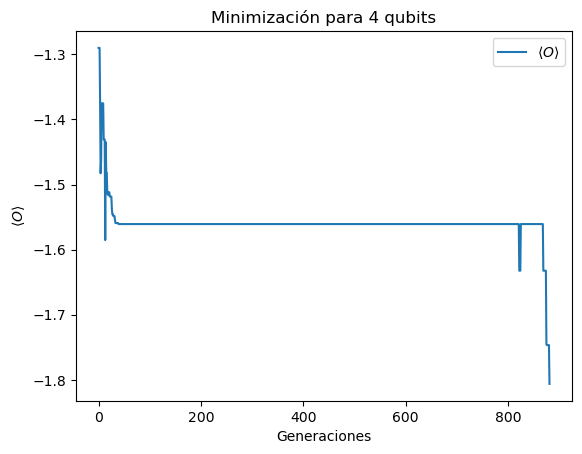

Fin ejecución con 4 qubits. Mínimo encontrado: -1.806230936021148

Preparando ejecución para 5 qubits.
Se usarán 21 parámetros


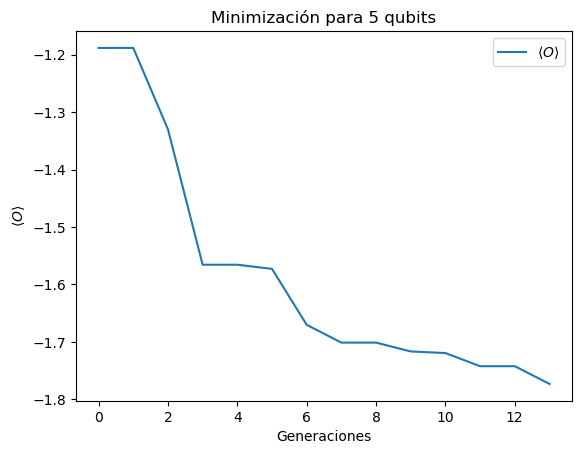

Fin ejecución con 5 qubits. Mínimo encontrado: -1.772946384946885

Preparando ejecución para 6 qubits.
Se usarán 27 parámetros


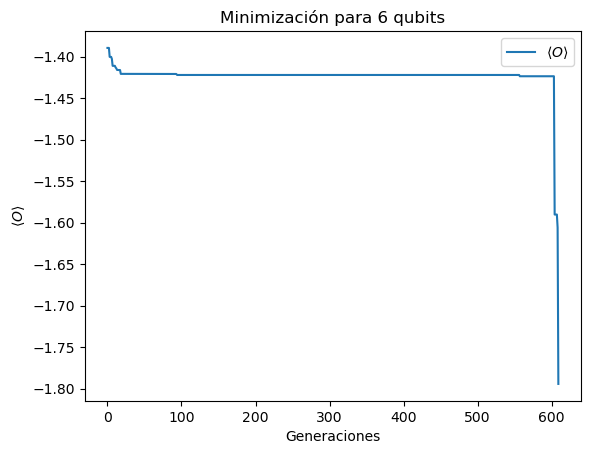

Fin ejecución con 6 qubits. Mínimo encontrado: -1.7944207671155898

Preparando ejecución para 7 qubits.
Se usarán 30 parámetros


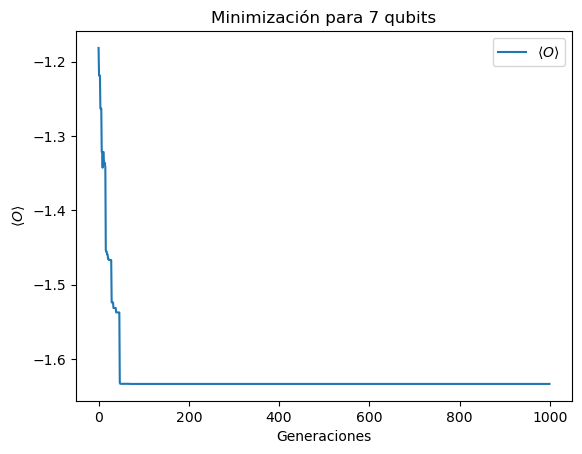

Fin ejecución con 7 qubits. Mínimo encontrado: -1.6335935937698132

Preparando ejecución para 8 qubits.
Se usarán 36 parámetros


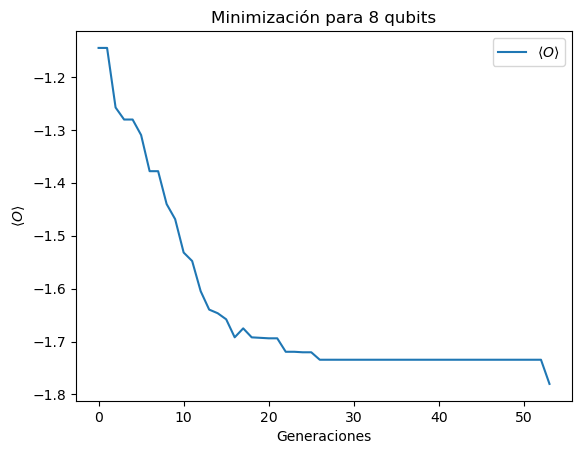

Fin ejecución con 8 qubits. Mínimo encontrado: -1.7800492691719458

Preparando ejecución para 9 qubits.
Se usarán 39 parámetros


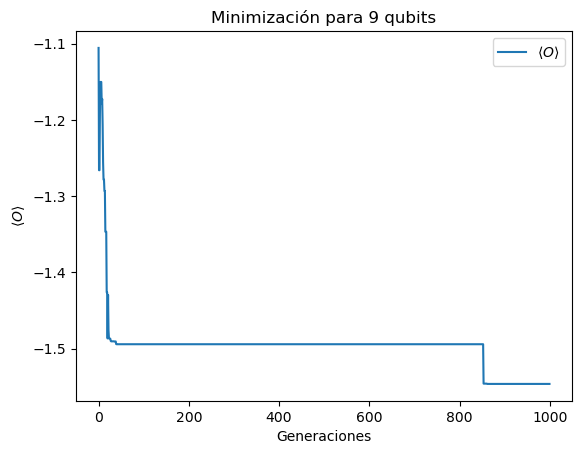

Fin ejecución con 9 qubits. Mínimo encontrado: -1.5464728893417703

Preparando ejecución para 10 qubits.
Se usarán 45 parámetros


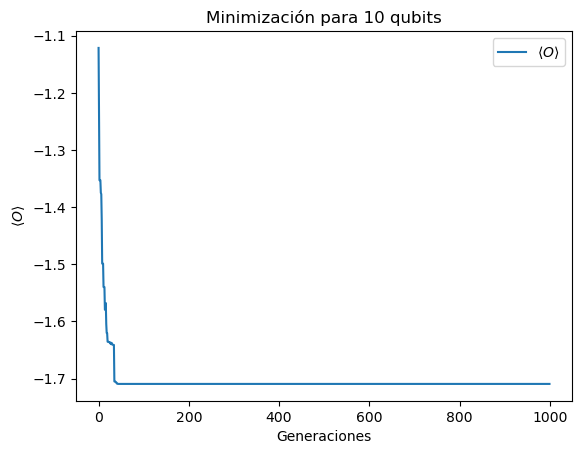

Fin ejecución con 10 qubits. Mínimo encontrado: -1.7092118934742961

Preparando ejecución para 11 qubits.
Se usarán 48 parámetros


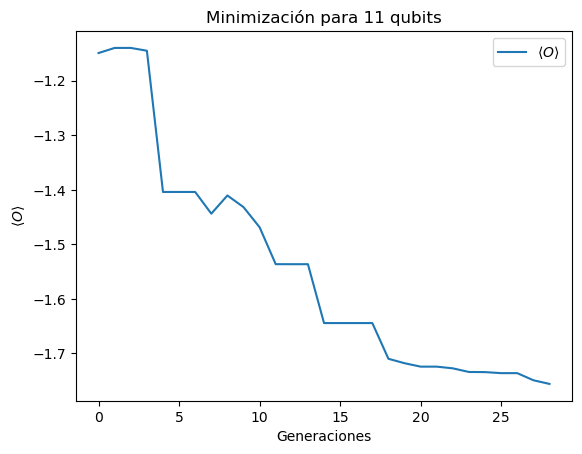

Fin ejecución con 11 qubits. Mínimo encontrado: -1.7558197627701506

Preparando ejecución para 12 qubits.
Se usarán 54 parámetros


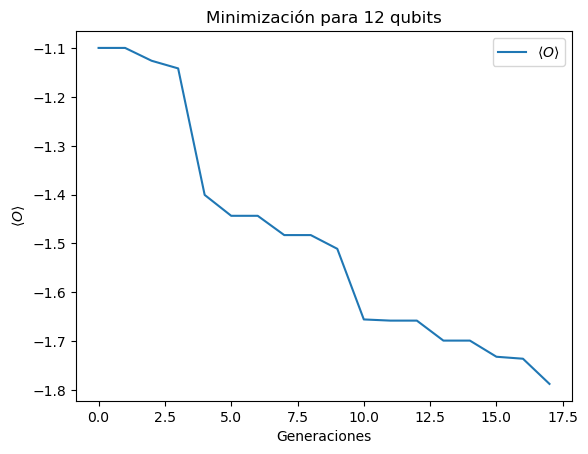

Fin ejecución con 12 qubits. Mínimo encontrado: -1.787521474723896


In [72]:
# Hamiltonians
with open(f"H2/data/hamiltonian0.719.pkl", "rb") as f:
    hamiltonian = pickle.load(f)


data = VQE_minimization_AG(anz.build_Nlocal_ansatz, 4, 12, hamiltonian, -1.75, population_size=100, max_iters=1000)



### 2-local ansatz


Preparando ejecución para 4 qubits.
Se usarán 8 parámetros


c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\juanl\miniconda3\envs\qiskit-tfm\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


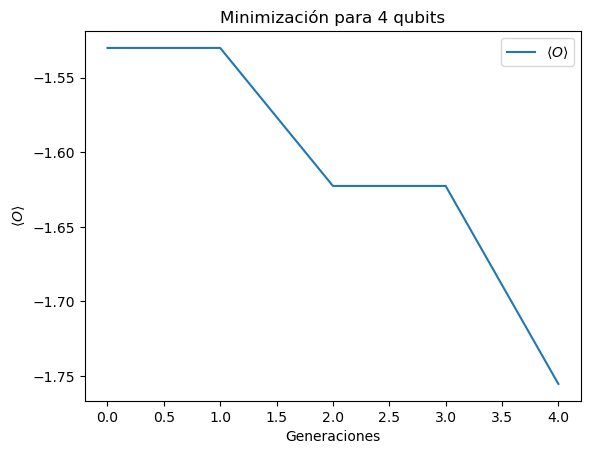

Fin ejecución con 4 qubits. Mínimo encontrado: -1.7552445699574724

Preparando ejecución para 5 qubits.
Se usarán 10 parámetros


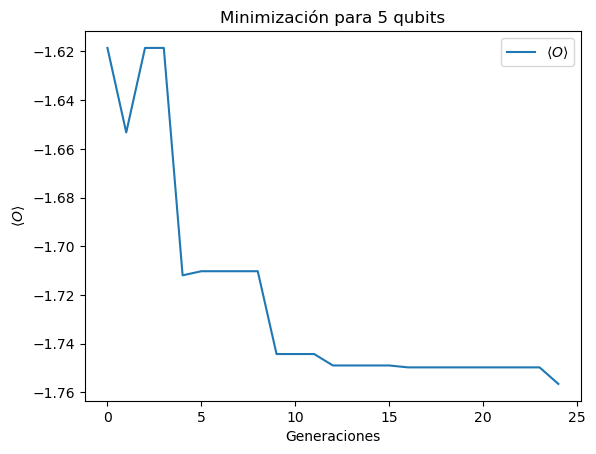

Fin ejecución con 5 qubits. Mínimo encontrado: -1.7565341660232363

Preparando ejecución para 6 qubits.
Se usarán 12 parámetros


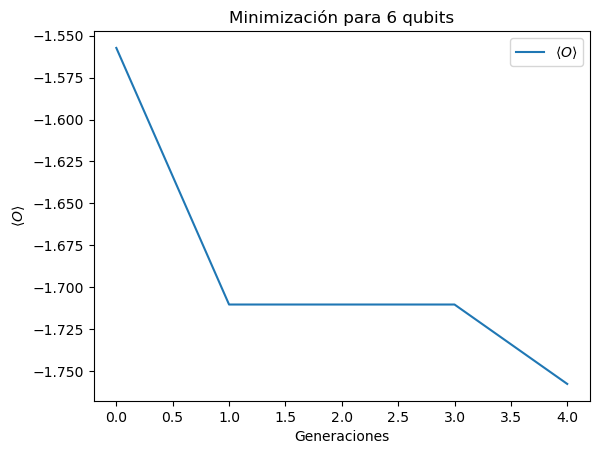

Fin ejecución con 6 qubits. Mínimo encontrado: -1.7577245557520356

Preparando ejecución para 7 qubits.
Se usarán 14 parámetros


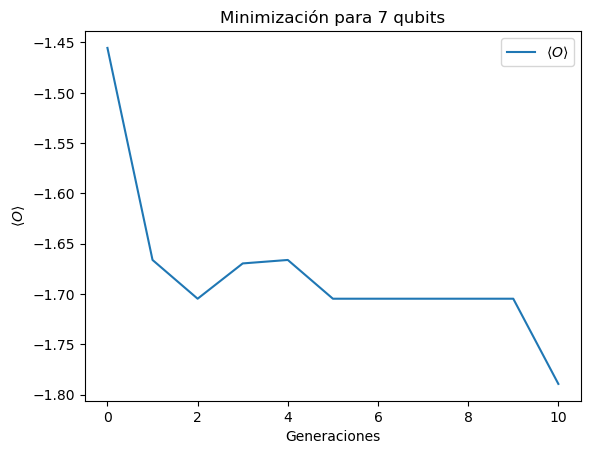

Fin ejecución con 7 qubits. Mínimo encontrado: -1.7894236189228065

Preparando ejecución para 8 qubits.
Se usarán 16 parámetros


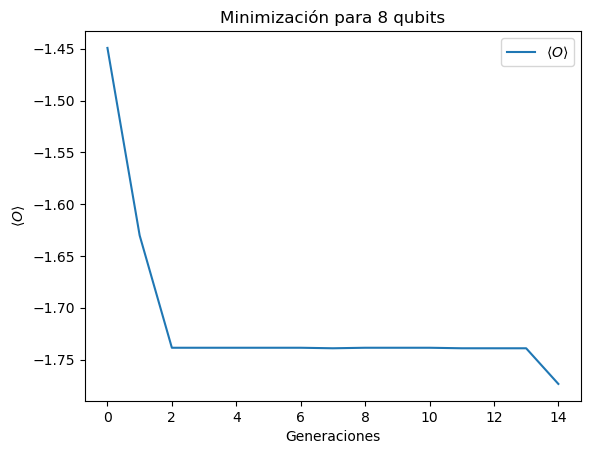

Fin ejecución con 8 qubits. Mínimo encontrado: -1.7734908516715155

Preparando ejecución para 9 qubits.
Se usarán 18 parámetros


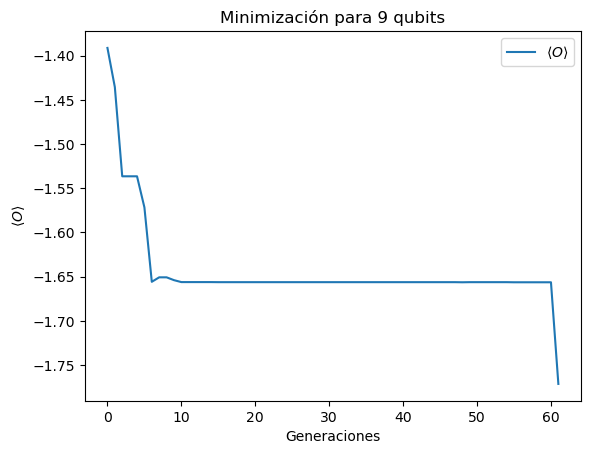

Fin ejecución con 9 qubits. Mínimo encontrado: -1.7712282998447018

Preparando ejecución para 10 qubits.
Se usarán 20 parámetros


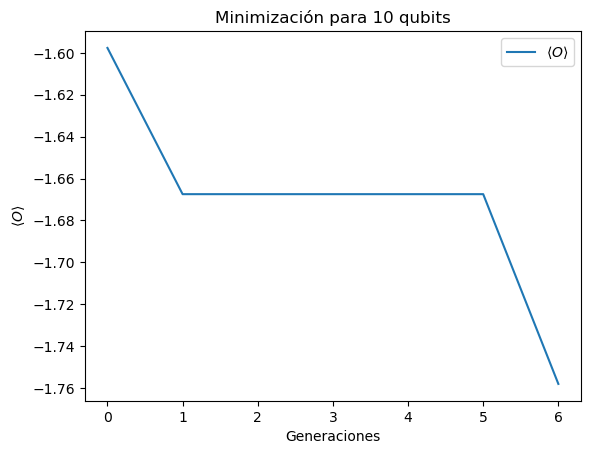

Fin ejecución con 10 qubits. Mínimo encontrado: -1.7580705428155485

Preparando ejecución para 11 qubits.
Se usarán 22 parámetros


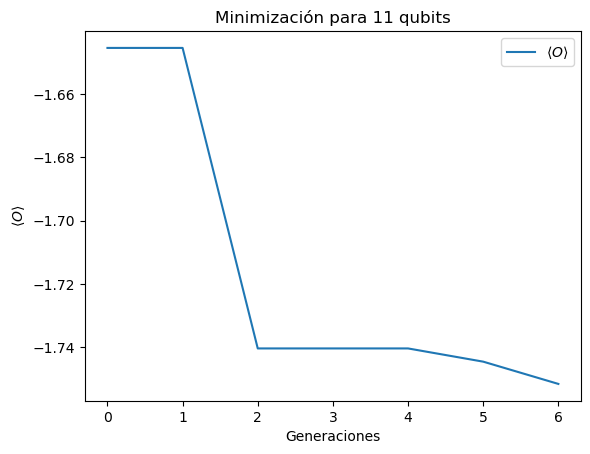

Fin ejecución con 11 qubits. Mínimo encontrado: -1.7515318700467986

Preparando ejecución para 12 qubits.
Se usarán 24 parámetros


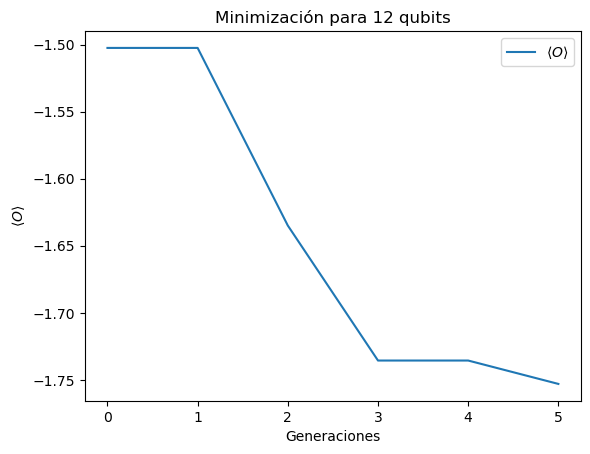

Fin ejecución con 12 qubits. Mínimo encontrado: -1.7530392556073435


In [73]:
data2 = VQE_minimization_AG(anz.build_twoLocal_ansatz, 4, 12, hamiltonian, -1.75, population_size=100, max_iters=1000)